In [580]:
import pickle
file = open('rates.dat', 'rb') # rates that were estimated in working_file.ipynb
ar_adj = pickle.load(file)
dep_adj = pickle.load(file)
file.close()

In [581]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#f2f2f2'
%matplotlib inline

In [582]:
def sim_station(arrival_rate, departure_rate, days_, silent = False):
    '''
    simulate station demand; it can be modelled as a M/M/1 queue without waiting time
    or as a sum of 2 independent time-inhomogeneous Poisson processes;
    we approximate continuous intensity rate with piecewise-constant function 
    
    return both demand and observed occupancy
    
    '''
    if not silent:
        fig, ax = plt.subplots(1, 1, figsize=(12,6))
        fig1, ax1 = plt.subplots(1, 1, figsize=(12,7))        
        ax.set_ylim(-90, 40)
        ax1.set_ylim(-10, 40)
    k = 1
    inds = []
    realizations = []
    realizations_finite = []
    for i in range(days_):
        rates = arrival_rate.values
        arrival_times = []
        for hour in range(len(rates)):
            n_arrivals = np.random.poisson(lam=rates[hour%len(rates)]*24/len(rates)) #* np.max([1+np.random.normal(0, 0.5), 0.0001]))  
            for x in range(n_arrivals):
                arrival_times = np.append(arrival_times, np.random.uniform() + hour)
        arrival_times = sorted(arrival_times)

        rates = [abs(x) for x in departure_rate.values]
        departure_times = []
        for hour in range(len(rates)):
            n_departures = np.random.poisson(lam=rates[hour%len(rates)]*24/len(rates)) #* np.max([1+np.random.normal(0, 0.5), 0.0001]))
            for x in range(n_departures):
                departure_times = np.append(departure_times, np.random.uniform() + hour)
        departure_times = sorted(departure_times)

        arr = pd.DataFrame(arrival_times)
        arr['arr'] = np.ones(len(arrival_times))
        dep = pd.DataFrame(departure_times)
        dep['arr'] = [-x for x in np.ones(len(departure_times))]
        arr = arr.append(dep).sort_values(by = 0)

        start = np.random.randint(26, 31)
        occupancy = start + np.cumsum(arr['arr'])
        occupancy_finite = []
        prev = start
        for x in arr['arr']:
            if (prev + x >= 0) & (prev + x <= 30):
                prev = prev + x
                occupancy_finite.append(prev)
            else:       
                occupancy_finite.append(prev)
        arr['occupancy'] = occupancy        
        arr = arr.reset_index(drop=True)
        result = ['{0:02.0f}:{1:02.0f}'.format(*divmod(x * 60, 60)) for x in arr[0]/len(rates)*24]
        for j, x in enumerate(result):
            if '60' in x:
                result[j] = x.replace('60', '59')
            if '24:' in x:
                result[j] = ('23:59')

        arr.index = [datetime.datetime.strptime(x, '%H:%M') for x in result]

        arr1 = arr['occupancy'].resample('2T').mean().bfill()
        arr1.index = arr1.index.map(lambda t: t.replace(year=2007, month=6, day=1))
        ind = arr1.index.map(lambda t: t.replace(year=2007, month=6, day=1+k))
        inds.append(ind)
        k += 1
        arr1 = arr1.apply(lambda x: round(x, 0))
        if not silent:       
            ax.plot(arr1, alpha = 0.4, color = 'dodgerblue')
        realizations.append(arr1)
        arr_finite = pd.DataFrame(arrival_times)
        arr_finite['arr_finite'] = np.ones(len(arrival_times))
        dep_finite = pd.DataFrame(departure_times)
        dep_finite['arr_finite'] = [-x for x in np.ones(len(departure_times))]
        arr_finite = arr_finite.append(dep_finite).sort_values(by = 0)
        arr_finite['occupancy_finite'] = occupancy_finite     
        arr_finite = arr_finite.reset_index(drop=True)
        result = ['{0:02.0f}:{1:02.0f}'.format(*divmod(x * 60, 60)) for x in arr_finite[0]/len(rates)*24]
        for j, x in enumerate(result):
            if '60' in x:
                result[j] = x.replace('60', '59')
            if '24:' in x:
                result[j] = ('23:59')

        arr_finite.index = [datetime.datetime.strptime(x, '%H:%M') for x in result]

        arr1_finite = arr_finite['occupancy_finite'].resample('2T').mean().bfill()
        arr1_finite.index = arr1_finite.index.map(lambda t: t.replace(year=2007, month=6, day=1))
        arr1_finite = arr1_finite.apply(lambda x: round(x, 0))
        if not silent:
            ax1.plot(arr1_finite, alpha = 0.4, color = 'dodgerblue')
        realizations_finite.append(arr1_finite)
    return realizations, inds, realizations_finite

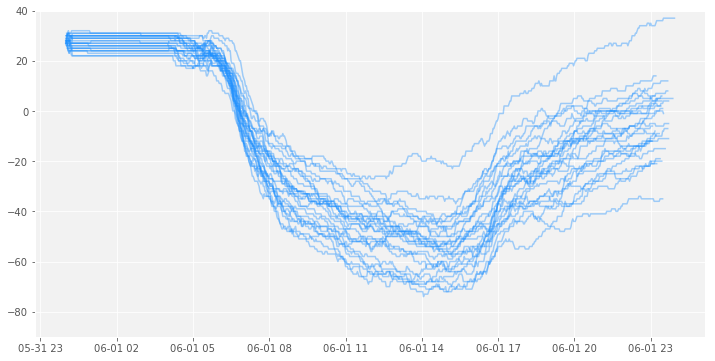

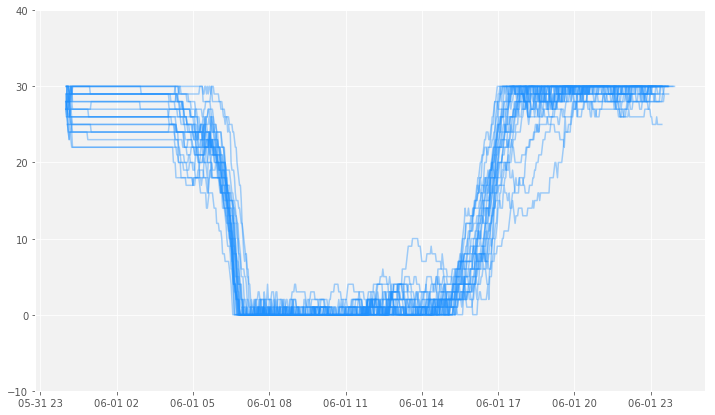

In [583]:
realizations, inds, realizations_finite = sim_station(ar_adj, dep_adj, days_ = 25)

In [584]:
inds = [x for subset in inds for x in subset]
realizations = [x for subset in realizations for x in subset]
realizations = pd.Series(realizations)
realizations.index = inds
inds_finite = inds #[x for subset in inds for x in subset]
realizations_finite = [x for subset in realizations_finite for x in subset]
realizations_finite = pd.Series(realizations_finite)
realizations_finite.index = inds_finite
realizations_finite_data = pd.DataFrame(realizations_finite)
realizations_finite_data.columns = ['occ']

In [585]:
def estimate_adjusted_rate_sim(data, step_size, silent = False):
    pb_weekdays = data
    diff = pb_weekdays.diff()
    diff[diff.isnull()] = 0
    pb_weekdays['difference'] = diff
    pb_weekdays['difference'] = [x for x in pb_weekdays.difference]
    pb_weekdays['maxval'] = [2 if x == 30 else 0 for x in pb_weekdays.occ]
    pb_weekdays['minval'] = [2 if x == 0 else 0 for x in pb_weekdays.occ]
    pb_weekdays['sum_diffs_arr'] = [x if x > 0 else 0 for x in pb_weekdays.difference]
    pb_weekdays['sum_diffs_dep'] = [x if x < 0 else 0 for x in pb_weekdays.difference]
    pb_weekdays['valid_arr_time'] = [2 if y == 0 else 0 for y in pb_weekdays.maxval]
    pb_weekdays['valid_dep_time'] = [2 if y == 0 else 0 for y in pb_weekdays.minval]

    pb_weekdays = pd.DataFrame(pb_weekdays.resample(str(step_size)+'T').sum())
    pb_weekdays['time'] = pb_weekdays.index.to_series().apply(lambda x: datetime.datetime.strftime(x, '%H:%M'))
    pb_weekdays['arr_rate'] = pb_weekdays.sum_diffs_arr / (pb_weekdays.valid_arr_time / 60)
    pb_weekdays['dep_rate'] = pb_weekdays.sum_diffs_dep / (pb_weekdays.valid_dep_time / 60)
    pb_weekdays[pb_weekdays['arr_rate'].isnull()] = 0
    pb_weekdays[pb_weekdays['arr_rate'] == np.inf] = 0
    pb_weekdays[pb_weekdays['dep_rate'].isnull()] = 0
    pb_weekdays[pb_weekdays['dep_rate'] == np.inf] = 0
    pb_weekdays[pb_weekdays['arr_rate'] == -np.inf] = 0
    pb_weekdays[pb_weekdays['dep_rate'] == -np.inf] = 0
    diff_arr_12 = pb_weekdays.groupby('time').agg('mean')['arr_rate'][1:]
    diff_dep_12 = -pb_weekdays.groupby('time').agg('mean')['dep_rate'][1:]
    #diff_arr_12['00:00'] = 0
    #diff_dep_12['00:00'] = 0
    diff_arr_12['23:30'] = diff_arr_12['23:00'].copy()
    diff_dep_12['23:30'] = diff_dep_12['23:00'].copy()
    if not silent:
        figure, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 6))
        ax1.set_ylabel('rate (events per hour)')
        ax1.set_title('Arrival rate. Interval: {} min'.format(step_size))
        diff_arr_12.plot(alpha=0.7, color = 'dodgerblue', ax = ax1)
        ax2.set_title('Departure rate. Interval: {} min'.format(step_size))
        ax2.set_ylabel('rate (events per hour)')
        diff_dep_12.plot(alpha=0.7, color = 'dodgerblue', ax=ax2)
        
    diff = data['occ'].diff()
    diff[diff.isnull()] = 0
    diff_arr_1 = pd.DataFrame(diff[diff >= 0].resample(str(step_size)+'T').sum()) * 60/step_size
    diff_dep_1 = pd.DataFrame(diff[diff <= 0].resample(str(step_size)+'T').sum()) * 60/step_size
    diff_arr_1['time'] = diff_arr_1.index.to_series().apply(lambda x: datetime.datetime.strftime(x, '%H:%M'))
    diff_arr_1 = diff_arr_1.groupby('time').agg('mean')
    diff_dep_1['time'] = diff_dep_1.index.to_series().apply(lambda x: datetime.datetime.strftime(x, '%H:%M'))
    diff_dep_1 = -diff_dep_1.groupby('time').agg('mean')
    if not silent:
        diff_arr_1[station].plot(alpha=0.7, color = 'indianred', ax = ax1)
        diff_dep_1[station].plot(alpha=0.7, color = 'indianred', ax=ax2)
    return diff_arr_12, diff_dep_12, diff_arr_1, diff_dep_1
        
        
    

In [586]:
arr_adj_hat, dep_adj_hat,  arr_hat, dep_hat = estimate_adjusted_rate_sim(realizations_finite_data, 15, silent = True)

In [587]:
sarradj = ar_adj
sarradjhat = arr_adj_hat
sarrhat = arr_hat

sdepadj = dep_adj
sdepadjhat = dep_adj_hat
sdephat = dep_hat

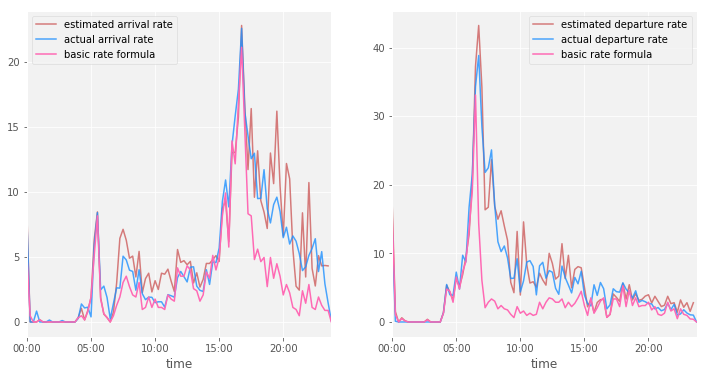

In [588]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
arr_adj_hat.plot(alpha = 0.8, color = 'indianred', ax = ax1)
ar_adj.plot(alpha = 0.8, color = 'dodgerblue', ax=ax1)
arr_hat.plot(ax = ax1, color = 'hotpink')
ax1.legend(['estimated arrival rate', 'actual arrival rate', 'basic rate formula'])



dep_adj_hat.plot(alpha = 0.8, color = 'indianred', ax = ax2)
dep_adj.plot(alpha = 0.8, color = 'dodgerblue', ax=ax2)
dep_hat.plot(ax = ax2, color = 'hotpink')



ax2.legend(['estimated departure rate', 'actual departure rate', 'basic rate formula']);

In [507]:
dep_adj_hat['23:45'] = dep_adj_hat['23:30'].copy()

In [509]:
np.sqrt(mean_squared_error(y_true = ar_adj, y_pred = arr_hat)) , np.sqrt(mean_squared_error(y_true = ar_adj, y_pred = arr_adj_hat))

(2.6346418617708607, 1.9570392433288726)

In [510]:
np.sqrt(mean_squared_error(y_true = dep_adj, y_pred = dep_hat)) , np.sqrt(mean_squared_error(y_true = dep_adj, y_pred = dep_adj_hat))

(6.514746796707152, 3.0144878061254916)

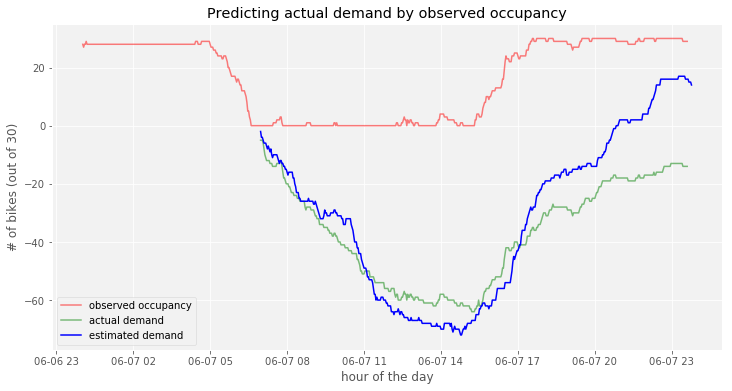

In [478]:
d_true = []
d_pred = []
ar11 = []
true11 = []
days = np.unique(realizations_finite.index.date)
DAY = 7
d = days[DAY-2]
day = realizations_finite[realizations_finite.index.date == d]
arr_adj_hat, dep_adj_hat, _, _ = estimate_adjusted_rate_sim(realizations_finite_data, 15, silent = True)

arr_adj_hat.index = [datetime.datetime.strptime(x, '%H:%M') for x in arr_adj_hat.index]
dep_adj_hat.index = [datetime.datetime.strptime(x, '%H:%M') for x in dep_adj_hat.index]
arr_rate = arr_adj_hat[arr_adj_hat.index.time >= day.index[np.min(np.where(realizations_finite == 0))].time()]
dep_rate = dep_adj_hat[dep_adj_hat.index.time >= day.index[np.min(np.where(realizations_finite == 0))].time()]
arrival_times = []
for hour in range(len(arr_rate)):
    n_arrivals = np.random.poisson(lam=arr_rate[hour%len(arr_rate)]*24/len(arr_rate))# * np.max([1+np.random.normal(0, 0.5), 0.0001]))  
    for x in range(n_arrivals):
        arrival_times = np.append(arrival_times, np.random.uniform() + hour)
arrival_times = sorted(arrival_times)
departure_times = []
for hour in range(len(dep_rate)):
    n_departures = np.random.poisson(lam=dep_rate[hour%len(dep_rate)]*24/len(dep_rate))#* np.max([1+np.random.normal(0, 0.5), 0.0001]))
    for x in range(n_departures):
        departure_times = np.append(departure_times, np.random.uniform() + hour)

departure_times = sorted(departure_times)
arr = pd.DataFrame(arrival_times)
arr['arr'] = np.ones(len(arrival_times))
dep = pd.DataFrame(departure_times)
dep['arr'] = [-x for x in np.ones(len(departure_times))]
arr = arr.append(dep).sort_values(by = 0)

start = 0
occupancy = start + np.cumsum(arr['arr'])
arr['occupancy'] = occupancy
arr = arr.reset_index(drop=True)

result = ['{0:02.0f}:{1:02.0f}'.format(*divmod(x * 60, 60)) for x in arr[0]/len(arr_adj_hat)*24]
for j, x in enumerate(result):
    if '60' in x:
        result[j] = x.replace('60', '59')
    if '24:' in x:
        result[j] = ('23:59')

result = [datetime.datetime.strptime(x, '%H:%M') for x in result]
result = [x + datetime.timedelta(hours =  day.index[np.min(np.where(realizations_finite == 0))].hour, minutes = day.index[np.min(np.where(realizations_finite == 0))].minute) for x in result]

arr.index = [datetime.datetime.strftime(x, '%H:%M') for x in result]
arr.index = pd.to_datetime(arr.index)
arr1 = arr['occupancy'].resample('2T').mean().bfill()
arr1 = arr1.apply(lambda x: round(x, 0))
k += 1
arr1.index = arr1.index.map(lambda t: t.replace(year=2007, month=6, day=DAY))
ar11.append(arr1)
true_demand = realizations[(realizations.index.date == d)&(realizations.index.time >= arr1.index.time[0])]
true11.append(true_demand)
d_true.append(true_demand)
d_pred.append(predicted_demand) 

true_demand = realizations[(realizations.index.date == d)&(realizations.index.time >= arr1.index.time[0])]
predicted_demand = arr1[arr1.index.isin(true_demand.index)]

fig, ax = plt.subplots(1,1, figsize=(12,6))
plt.plot(day, color = 'r', alpha = 0.5)
plt.plot(true_demand, color = 'g', alpha = 0.5)
plt.plot(arr1, color = 'b')
plt.legend(['observed occupancy', 'actual demand', 'estimated demand'])
plt.title('Predicting actual demand by observed occupancy')
plt.ylabel('# of bikes (out of 30)')
plt.xlabel('hour of the day')
ax.xaxis.label.set_fontsize(12)
ax.yaxis.label.set_fontsize(12)
#fig.savefig('demand_prediction.png')

In [426]:
rmses = []

for x in range(1, 162, 20):
    rmse = bss_functions.repeat_simulation_est(estimate_adjusted_rate_sim, sim_station, ar_adj, dep_adj, x)
    rmses.append(x)

Successfully calculated RMSE for 29 days: 6.282218544532643
Successfully calculated RMSE for 609 days: 25.766971551419193
Successfully calculated RMSE for 1189 days: 19.924120511067926
Successfully calculated RMSE for 1769 days: 23.056890157364432
Successfully calculated RMSE for 2349 days: 20.061410023920754
Successfully calculated RMSE for 2929 days: 22.19321183555775
Successfully calculated RMSE for 3509 days: 23.007375459696835
Successfully calculated RMSE for 4089 days: 22.230277041498997
Successfully calculated RMSE for 4669 days: 23.03325918370099
